We are performing image transformation in the **Spatial Domain**, by directly manipulating the pixels.

Pre Running Code:
- We will access the files section and upload our 4 images on the session storage.
- grey_1.png is the Panda
- grey_2.png is the Lady
- grey_3.png is the Town
- grey_4.png is the Man (Elon)
- Here after, we will run all code blocks.



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Histogram equalization

In this code block, I have performed a histogram equalisation on a given image. The first function deals with freqyency vs pixel intensity generation array and the other two fuctions act as functions that help with the actual equalisation.

In [ ]:
#this function is used to count the frequency of intensities from (0,255)
#In this function I am creating a 2D matrix of the Pixels of the image

def pixel_list_converter1(image_input):

  pixel_values = np.array(image_input)
  #this calculates frequency of each intensity
  intensity_list = np.zeros(256, dtype=int)

  for y in range(512):
    for x in range(512):
      intensity_list[pixel_values[x,y]] += 1


  return (pixel_values, intensity_list)



def histogram_equalizer1(intensity_list):

    sum_intensity = np.sum(intensity_list,dtype=int)
    pmf_list = intensity_list / sum_intensity
    cdf_list = np.cumsum(pmf_list) * 255
    equalized_list = np.round(cdf_list).astype(int)
    #np.round rounds them off, astype(int) converts the numbers to integer
    return equalized_list


def histogram_equalization(name):

  source_img=source_img = cv2.imread(name,0)
  (img_pix,intensity_freq_original) = pixel_list_converter1(source_img)

  intensity_equalized = histogram_equalizer1(intensity_freq_original)

  return (intensity_equalized, intensity_freq_original, img_pix)

# Histogram Matching

This is the code block for matching two Frequency vs Intensity arrays of a source and a target. We then, equalize these two arrays, ideally the input arrays are equalized but equalziing them again is fine. We then make two dictionaries and appropriately map the values so as to create the final matching.

In [ ]:
def histogram_matching(source_data, target_data):

  final_matched={}

  reversed_target={}

  #re-equalization
  sum_intensity = np.sum(source_data,dtype=int)
  pmf_list = source_data / sum_intensity
  cdf_list = np.cumsum(pmf_list) * 255
  source_data = np.round(cdf_list).astype(int)

  sum_intensity = np.sum(target_data,dtype=int)
  pmf_list = target_data / sum_intensity
  cdf_list = np.cumsum(pmf_list) * 255
  target_data = np.round(cdf_list).astype(int)

  for index in range(len(target_data)):
        reversed_target[target_data[index]] = index

  corrected_source={}

  for index in range(len(source_data)):
        corrected_source[index] = source_data[index]

  reversed_target = dict(sorted(reversed_target.items(), key=lambda item: item[0]))
  corrected_source = dict(sorted(corrected_source.items(), key=lambda item: item[0]))

  rt_keys = list( reversed_target.keys() )

  dynamic_threshold = np.std(list(corrected_source.keys())).astype(int)

  for source_key in list(corrected_source.keys()):
        source_value = corrected_source[source_key]

        if source_value in rt_keys:
            final_matched[source_key] = reversed_target[source_value]
        else:
          for target_key in rt_keys:
              if abs(source_value - target_key) <= dynamic_threshold:
                  final_matched[source_key] = reversed_target[target_key]
                  break

  return final_matched

# Image making and saving

We perform two functions to rebuild our final image based on the original data of the source and the new data after matching of histograms.

In [ ]:
def image_maker(final_data, original_image):

  final_image = np.zeros((512,512),dtype=int)

  for y in range(512):
    for x in range(512):
      greyscale_intensity = original_image[y,x]

      if greyscale_intensity in final_data.keys():
        new_gs_intensity = final_data[greyscale_intensity]
        final_image[y,x] =  new_gs_intensity
      else:
        final_image[y,x]=original_image[y,x]


  return_image = [[[x, x, x] for x in row] for row in final_image]
  return return_image

def final_img_save(pixel_list,s):

    pixel_array = np.zeros((512, 512, 3), dtype=np.uint8)
    for y in range(512):
      for x in range(512):
         pixel_array[y, x] = pixel_list[y][x]
    image = Image.fromarray(pixel_array)
    image.save(s)

# Main Function

This is the function that performs the main task of the assignment. This function processes the image, then calculates the frequencies of intensities and equalizes them, from both source and target, then matches the histogram and finally plots the images.

This function has a lot of sub functions which are written above.

In [ ]:
def final_function(source,target,filename):

  (eq_data_source, pre_data_source,coordinate_source) = histogram_equalization(source)
  (eq_data_target, pre_data_target,coordinate_target) = histogram_equalization(target)

  matched_data = histogram_matching(eq_data_source , eq_data_target)


  final_pixels = image_maker(matched_data, coordinate_source)
  final_img_save(final_pixels,filename)

  image = Image.open(filename)

  image_paths = [source, target, filename]

  fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 3))
  i=0
  for image_path in image_paths:
    img = Image.open(image_path)
    if i == 0:
      a="Source"
    elif i ==1:
      a="Target"
    else:
      a="Matched"
    axes[i].set_title(f"Image {a}")
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    i+=1
  plt.show()


# Histogram plotter -> Image, Non-Equalized histogram and Equalized histogram

In this code block I shall perform the first funciton of opening my image, plotting the graph of it's frequency vs pixel intensity for non equalized (original values) and then the equalized histogram.


In [ ]:
def plot_histogram(source):

  (equalized_cdfs, frequency_intensities,coordinates) = histogram_equalization(source)

  img = Image.open(source).convert('L')
  greyscale_img = np.array(img)

  plt.figure(figsize=(15, 3))

  #original image
  plt.subplot(1, 3, 1)
  plt.imshow(greyscale_img, cmap='gray')
  plt.title(f"Image name : {source}")

  #non-equalized graph
  plt.subplot(1, 3, 2)
  plt.bar(np.linspace(0, 256, 256), frequency_intensities, color='red',edgecolor='red')
  plt.title(f"Histogram Non-equalized : {source}")

  #equalized graph
  equalized_graph = np.zeros(256)
  count = 0
  for i in range(256):
      equalized_graph[equalized_cdfs[i]] = frequency_intensities[i]

  plt.subplot(1, 3, 3)
  plt.bar(np.linspace(0, 256, 256), equalized_graph, color='green')
  plt.title(f"Histogram Equalized : {source}")

  plt.show()

# Final Code Block

In order to execute all the code and see the workings of the task, the lower code block is to be run.

This code block will first plot all 4 images used and their respective non equalized and equalized, **frequency vs pixel intensity** or plot.

Then, this code will perform histogram equalization and matching with a given algorithm in order to generate a final matched image.

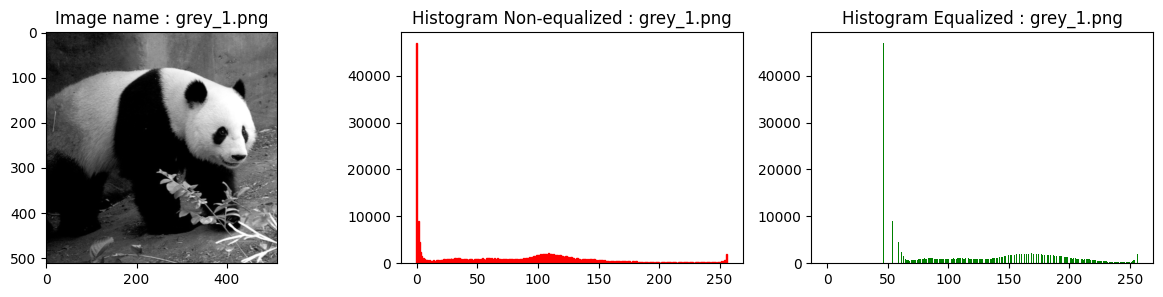

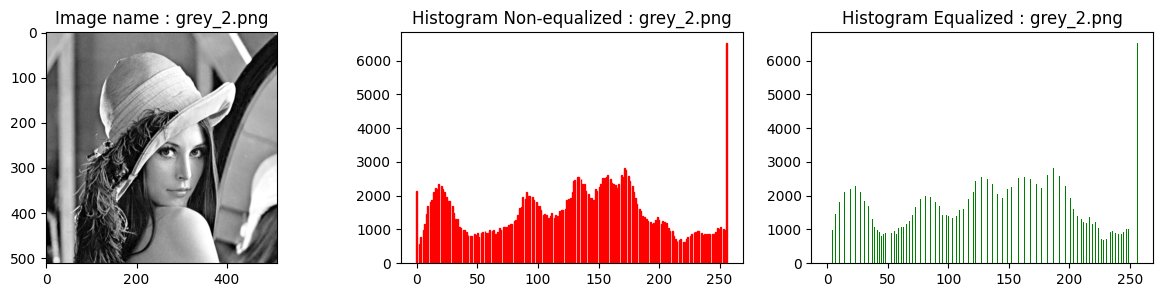

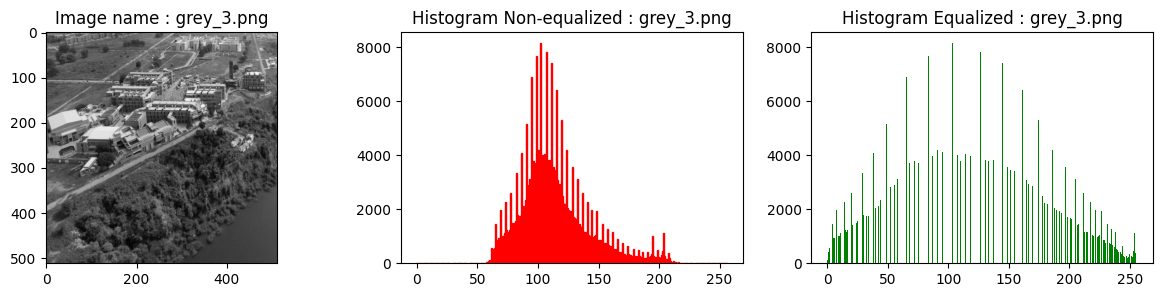

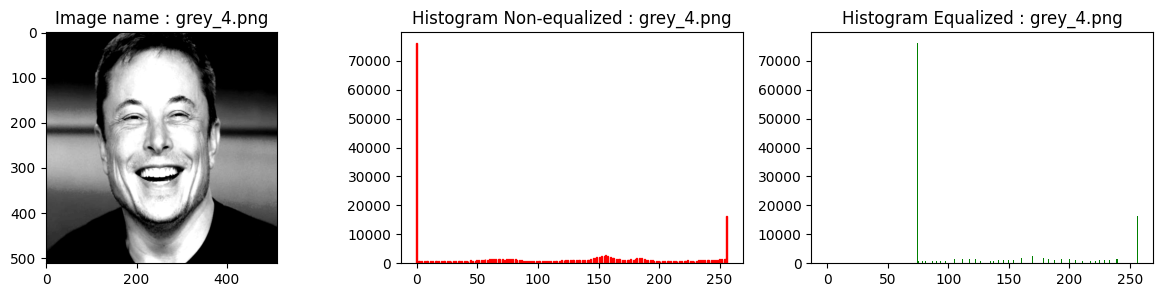

256
256


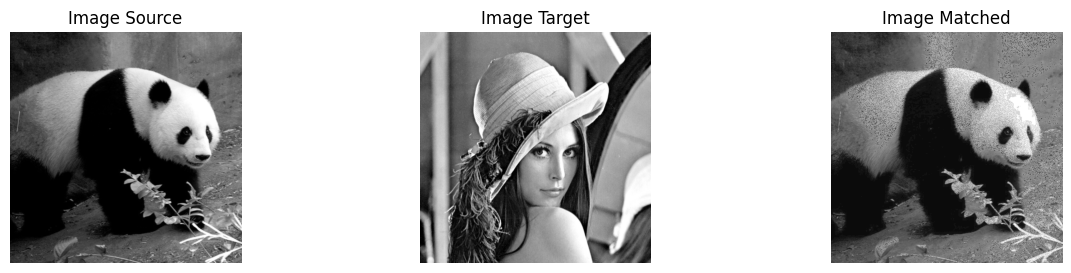

256
256


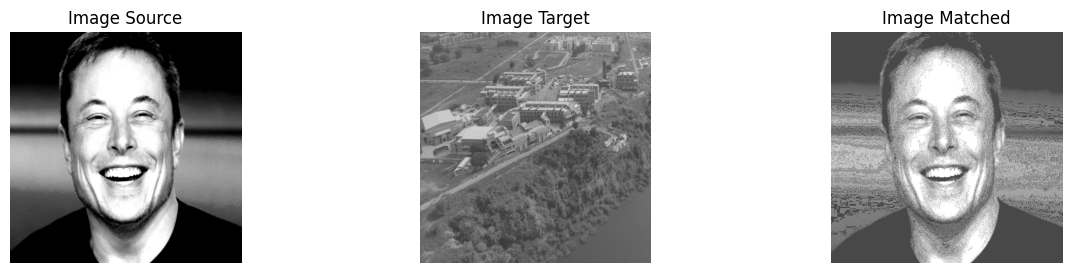

256
256


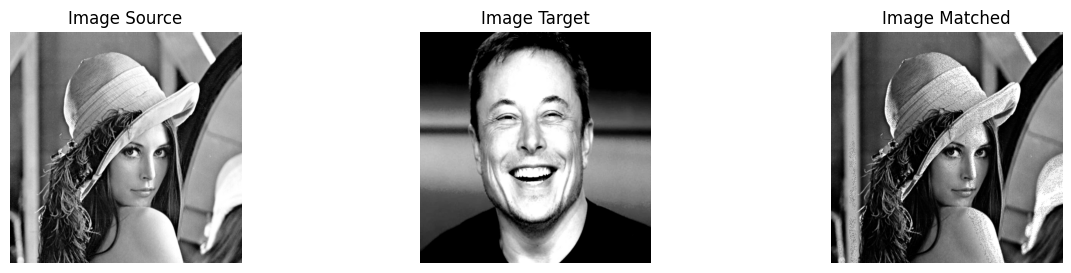

256
256


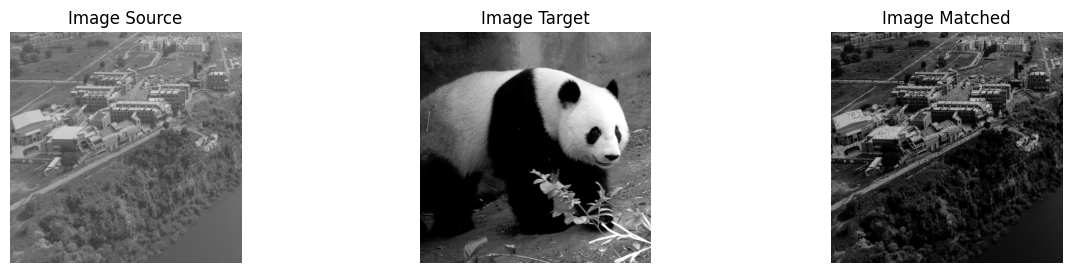

In [ ]:
plot_histogram("grey_1.png")
plot_histogram("grey_2.png")
plot_histogram("grey_3.png")
plot_histogram("grey_4.png")

final_function("grey_1.png","grey_2.png","A_conversion1.png")
final_function("grey_4.png","grey_3.png","B_conversion2.png")
final_function("grey_2.png","grey_4.png","C_conversion3.png")
final_function("grey_3.png","grey_1.png","D_conversion4.png")

**Sources**

1. [Color Mixer](https://www.csfieldguide.org.nz/en/interactives/rgb-mixer/) : I used this to visualize how 0 to 255 is Black to White (Greyscale).
2. [Image Histogram Calculator](https://pinetools.com/image-histogram) : I used this to verify my Histogram plots.
3. [Medium Article](https://towardsdatascience.com/histogram-matching-ee3a67b4cbc1) : I used this to develop better conceptual clarity on the topic.
4. [Matplotlib documentation](https://matplotlib.org/stable/index.html) : I used this learn about graph plotting and image interpretation.
5. Interaction with peers: I interacted with my peers and discussed how even though we were able to solve the question, how taking different approaches, led to different output images.
